

# Preparing Environment


In [2]:
# Install packages
!pip install keras

#Import libraries
import keras
from keras import layers,optimizers

import numpy as np
from google.colab import files
import gzip

from keras.utils import to_categorical
from keras import backend as K
import tensorflow as tf
from keras import losses 
from keras.callbacks import Callback
from keras import callbacks
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation
from keras import layers,optimizers
from keras import regularizers
from keras.optimizers import Adam,Adadelta
from keras import regularizers
from keras import metrics
import requests,time
import tensorflow as tf

from random import randint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
# Download the dataset from cullpdb for ICML2014
!wget -O cullpdb+profile_6133_filtered.npy.gz "http://www.princeton.edu/~jzthree/datasets/ICML2014/cullpdb+profile_6133_filtered.npy.gz"

#Prepare the dataset
dataset = gzip.open('cullpdb+profile_6133_filtered.npy.gz', 'rb')
dataset = np.load(dataset)
print("Before: ",dataset.shape)
dataset = np.reshape(dataset, (dataset.shape[0], 700, 57))
print("After: ",dataset.shape)

--2018-06-08 12:41:21--  http://www.princeton.edu/~jzthree/datasets/ICML2014/cullpdb+profile_6133_filtered.npy.gz
Resolving www.princeton.edu (www.princeton.edu)... 140.180.223.42
Connecting to www.princeton.edu (www.princeton.edu)|140.180.223.42|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104563491 (100M) [application/x-gzip]
Saving to: ‘cullpdb+profile_6133_filtered.npy.gz’

cullpdb+profile_613 100%[===================>]  99.72M  2.98MB/s    in 34s     

2018-06-08 12:41:55 (2.95 MB/s) - ‘cullpdb+profile_6133_filtered.npy.gz’ saved [104563491/104563491]

Before:  (5534, 39900)
After:  (5534, 700, 57)


In [0]:
# OR use a uploaded file

uploaded = files.upload()

uploaded_file=''
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  uploaded_file = fn

# Prepare the dataset
dataset = uploaded_file
dataset = np.load(dataset)
print("Before: ",dataset.shape)
dataset = np.reshape(dataset, (dataset.shape[0], 700, 57)) # [Proteins|Aminoacids|Features]
print("After: ",dataset.shape)


In [5]:
# Prepare the datasets for classification

print('Preparing dataset...dataset shape ',dataset.shape )
dataindex = range(30) # aminoacids + secondary structure => input

t_end_idx=int(dataset.shape[0]*0.7)# 4427
v_idx = t_end_idx+ int(dataset.shape[0]*0.1)# 4980

np.random.seed(1234)
idx_arr = np.arange(dataset.shape[0])
np.random.shuffle(idx_arr)
traindataset = dataset[idx_arr,:,:]

print("traindataset.. ",traindataset.shape)
traindata = traindataset[:t_end_idx,:,dataindex]
trainlabel = traindataset[:t_end_idx,:,34:35] # acc relative (33) 
valdata = traindataset[t_end_idx:v_idx,:,dataindex]
vallabel = traindataset[t_end_idx:v_idx,:,34:35]

traindata = np.concatenate((traindata, valdata), axis=0)
trainlabel = np.concatenate((trainlabel, vallabel), axis=0)

testdata = traindataset[v_idx:,:,dataindex]
testlabel = traindataset[v_idx:,:,34:35]

print(
    "\n********Before:********\ntraindata.shape: ",traindata.shape,
      "\nvaldata.shape: ",valdata.shape,
      "\ntestdata.shape: ",testdata.shape,
      "\ntrainlabel.shape: ",trainlabel.shape,
      "\nvallabel.shape: ",vallabel.shape,
      "\ntestlabel.shape: ",testlabel.shape
    )

max_num_amino = 700

trainmask = dataset[:t_end_idx,:,30]* -1 + 1
valmask = dataset[t_end_idx:v_idx,:,30]* -1 + 1
testmask = dataset[v_idx:,:,30]* -1 + 1

trainvalmask = np.concatenate((trainmask, valmask), axis=0)

trainlabel = to_categorical(trainlabel,2)
testlabel = to_categorical(testlabel,2)
vallabel = to_categorical(vallabel,2)

train_tmp = []
train_lab_tmp = []
val_tmp = []
val_lab_tmp = []
test_tmp = []
test_lab_tmp = []

min_ratio = 0.1
max_ratio = 0.9
do_ratio = False


for i in range(valdata.shape[0]):
  p = valdata[i,:max_num_amino,:]
  pl = vallabel[i,:max_num_amino,:]
  num_amino = int(sum(valmask[i]))
  if(num_amino<=max_num_amino):
    ratio_first = (np.sum(pl[:num_amino,0])/num_amino)
    if do_ratio:
      if( min_ratio < ratio_first and ratio_first < max_ratio ):    
        val_tmp.append(p)
        pl[num_amino:,:]=[0,0]
        val_lab_tmp.append(pl)
    else:
      val_tmp.append(p)
      pl[num_amino:,:]=[0,0]
      val_lab_tmp.append(pl)

for i in range(traindata.shape[0]):
  p = traindata[i,:max_num_amino,:]
  pl = trainlabel[i,:max_num_amino,:]
  num_amino = int(sum(trainvalmask[i]))
  if(num_amino<=max_num_amino):
    ratio_first = (np.sum(pl[:num_amino,0])/num_amino)
    if do_ratio:
      if( min_ratio < ratio_first and ratio_first < max_ratio ):      
        train_tmp.append(p)
        pl[num_amino:,:]=[0,0]
        train_lab_tmp.append(pl)
    else:      
      train_tmp.append(p)
      pl[num_amino:,:]=[0,0]
      train_lab_tmp.append(pl)

for i in range(testdata.shape[0]):
  p = testdata[i,:max_num_amino,:]
  pl = testlabel[i,:max_num_amino,:]
  num_amino = int(sum(testmask[i]))
  if(num_amino<=max_num_amino):
    ratio_first = (np.sum(pl[:num_amino,0])/num_amino)
    if do_ratio:
      if( min_ratio < ratio_first and ratio_first < max_ratio ):    
        test_tmp.append(p)
        pl[num_amino:,:]=[0,0]
        test_lab_tmp.append(pl)
    else:    
      test_tmp.append(p)
      pl[num_amino:,:]=[0,0]
      test_lab_tmp.append(pl)

traindata = np.array(train_tmp).astype(float)
valdata = np.array(val_tmp).astype(float)
testdata = np.array(test_tmp).astype(float)
trainlabel = np.array(train_lab_tmp).astype(float)
vallabel = np.array(val_lab_tmp).astype(float)
testlabel = np.array(test_lab_tmp).astype(float)


print("\n********After:********\ntraindata.shape: ",traindata.shape,"\nvaldata.shape: ",valdata.shape,"\ntestdata.shape: ",testdata.shape,
      "\ntrainlabel.shape: ",trainlabel.shape,"\nvallabel.shape: ",vallabel.shape,"\ntestlabel.shape: ",testlabel.shape)

Preparing dataset...dataset shape  (5534, 700, 57)
traindataset..  (5534, 700, 57)

********Before:********
traindata.shape:  (4426, 700, 30) 
valdata.shape:  (553, 700, 30) 
testdata.shape:  (1108, 700, 30) 
trainlabel.shape:  (4426, 700, 1) 
vallabel.shape:  (553, 700, 1) 
testlabel.shape:  (1108, 700, 1)

********After:********
traindata.shape:  (4426, 700, 30) 
valdata.shape:  (553, 700, 30) 
testdata.shape:  (1108, 700, 30) 
trainlabel.shape:  (4426, 700, 2) 
vallabel.shape:  (553, 700, 2) 
testlabel.shape:  (1108, 700, 2)


In [0]:
def proteinCategoricalCrossentropy(y_true,y_pred):
      
      loss = y_true * K.log(y_pred)      
      loss = -K.sum(loss, -1)
      
      return loss

  
def stable_softmax(x, axis=-1):# based on keras implementation
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x - K.max(x,axis=axis, keepdims=True))
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D. '
                         'Received input: %s' % x)
  
def weighted_accuracy(y_true, y_pred):
    acc = K.sum(K.cast( K.equal(
                        K.argmax(y_true, axis=-1),
                        K.argmax((y_pred), axis=-1)
                    ),"float32") * K.sum(y_true, axis=-1)
                ) / K.sum(y_true)
    return acc
    
train_accs = []
val_accs = []

class ProteinCallback(Callback):
  def __init__(self, eval_data):
      self.eval_data = eval_data
      
  def on_epoch_end(self, epoch, logs={}):
        x, y = self.eval_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('Testing loss: {}, weighted_accuracy: {}'.format(loss, acc))

In [0]:
#Save Data in gdrive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Convolutional neural network


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 700, 30)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 700, 16)           3376      
_________________________________________________________________
activation_1 (Activation)    (None, 700, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 700, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 700, 32)           3616      
_________________________________________________________________
activation_2 (Activation)    (None, 700, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 700, 32)           0         
__________

4426/4426 [==============================] - 6s 1ms/step - loss: 0.1346 - weighted_accuracy: 0.7538 - val_loss: 0.1233 - val_weighted_accuracy: 0.7781
Testing loss: 0.12723998074497125, weighted_accuracy: 0.7701354304375632
Epoch 2/80
4426/4426 [==============================] - 3s 627us/step - loss: 0.1229 - weighted_accuracy: 0.7826 - val_loss: 0.1162 - val_weighted_accuracy: 0.7966
Testing loss: 0.11955817624765183, weighted_accuracy: 0.7931690392511416
Epoch 3/80
4426/4426 [==============================] - 3s 641us/step - loss: 0.1144 - weighted_accuracy: 0.8078 - val_loss: 0.1126 - val_weighted_accuracy: 0.8093
Testing loss: 0.11559737592074845, weighted_accuracy: 0.8045174556949078
Epoch 4/80
4426/4426 [==============================] - 3s 635us/step - loss: 0.1086 - weighted_accuracy: 0.8222 - val_loss: 0.1045 - val_weighted_accuracy: 0.8284
Testing loss: 0.10749786035140929, weighted_accuracy: 0.8241694109104171
Epoch 5/80
1568/4426 [=========>....................] - ETA: 1s -

4426/4426 [==============================] - 3s 634us/step - loss: 0.1051 - weighted_accuracy: 0.8302 - val_loss: 0.1013 - val_weighted_accuracy: 0.8343
Testing loss: 0.10477961589067851, weighted_accuracy: 0.829510303610929
Epoch 6/80
4426/4426 [==============================] - 3s 627us/step - loss: 0.1028 - weighted_accuracy: 0.8350 - val_loss: 0.1016 - val_weighted_accuracy: 0.8347
Testing loss: 0.10518827835360159, weighted_accuracy: 0.8298398492999025
Epoch 7/80
4426/4426 [==============================] - 3s 638us/step - loss: 0.1016 - weighted_accuracy: 0.8376 - val_loss: 0.1010 - val_weighted_accuracy: 0.8352
Testing loss: 0.1044619373358544, weighted_accuracy: 0.8308713864333362
Epoch 8/80
4426/4426 [==============================] - 3s 634us/step - loss: 0.1004 - weighted_accuracy: 0.8399 - val_loss: 0.0994 - val_weighted_accuracy: 0.8381
Testing loss: 0.10314347387866422, weighted_accuracy: 0.8331349474858721
Epoch 9/80
1472/4426 [========>.....................] - ETA: 1s -

4426/4426 [==============================] - 3s 632us/step - loss: 0.0993 - weighted_accuracy: 0.8420 - val_loss: 0.0967 - val_weighted_accuracy: 0.8442
Testing loss: 0.10106689079466279, weighted_accuracy: 0.8376036637096198
Epoch 10/80
4426/4426 [==============================] - 3s 631us/step - loss: 0.0990 - weighted_accuracy: 0.8429 - val_loss: 0.0974 - val_weighted_accuracy: 0.8414
Testing loss: 0.10224212017515506, weighted_accuracy: 0.833679021695891
Epoch 11/80
4426/4426 [==============================] - 3s 631us/step - loss: 0.0982 - weighted_accuracy: 0.8441 - val_loss: 0.0956 - val_weighted_accuracy: 0.8466
Testing loss: 0.10017099516594023, weighted_accuracy: 0.8396834453520792
Epoch 12/80
4426/4426 [==============================] - 3s 631us/step - loss: 0.0974 - weighted_accuracy: 0.8457 - val_loss: 0.0946 - val_weighted_accuracy: 0.8483
Testing loss: 0.09941988710031613, weighted_accuracy: 0.8408337005208976
Epoch 13/80
1376/4426 [========>.....................] - ETA:

4426/4426 [==============================] - 3s 638us/step - loss: 0.0971 - weighted_accuracy: 0.8464 - val_loss: 0.0948 - val_weighted_accuracy: 0.8471
Testing loss: 0.0993659253692799, weighted_accuracy: 0.840701581553862
Epoch 14/80
4426/4426 [==============================] - 3s 628us/step - loss: 0.0968 - weighted_accuracy: 0.8469 - val_loss: 0.0941 - val_weighted_accuracy: 0.8491
Testing loss: 0.09897372570386433, weighted_accuracy: 0.8412202381485205
Epoch 15/80
4426/4426 [==============================] - 3s 633us/step - loss: 0.0965 - weighted_accuracy: 0.8476 - val_loss: 0.0936 - val_weighted_accuracy: 0.8503
Testing loss: 0.09882262276505735, weighted_accuracy: 0.8420843062418032
Epoch 16/80
4426/4426 [==============================] - 3s 631us/step - loss: 0.0960 - weighted_accuracy: 0.8486 - val_loss: 0.0933 - val_weighted_accuracy: 0.8510
Testing loss: 0.09859225616558365, weighted_accuracy: 0.8416173131026946
Epoch 17/80
1280/4426 [=======>......................] - ETA: 

4426/4426 [==============================] - 3s 626us/step - loss: 0.0959 - weighted_accuracy: 0.8485 - val_loss: 0.0941 - val_weighted_accuracy: 0.8497
Testing loss: 0.09941149465336266, weighted_accuracy: 0.8404188799513806
Epoch 18/80
4426/4426 [==============================] - 3s 630us/step - loss: 0.0956 - weighted_accuracy: 0.8493 - val_loss: 0.0929 - val_weighted_accuracy: 0.8515
Testing loss: 0.09821242478672779, weighted_accuracy: 0.8426465559952526
Epoch 19/80
4426/4426 [==============================] - 3s 632us/step - loss: 0.0953 - weighted_accuracy: 0.8497 - val_loss: 0.0927 - val_weighted_accuracy: 0.8523
Testing loss: 0.09819741194751719, weighted_accuracy: 0.8422975544464717
Epoch 20/80
4426/4426 [==============================] - 3s 623us/step - loss: 0.0954 - weighted_accuracy: 0.8495 - val_loss: 0.0930 - val_weighted_accuracy: 0.8504
Testing loss: 0.09895834442402912, weighted_accuracy: 0.8409444885563764
Epoch 21/80
1376/4426 [========>.....................] - ETA

4426/4426 [==============================] - 3s 624us/step - loss: 0.0949 - weighted_accuracy: 0.8506 - val_loss: 0.0923 - val_weighted_accuracy: 0.8525
Testing loss: 0.09815998945640743, weighted_accuracy: 0.8431672029977241
Epoch 22/80
4426/4426 [==============================] - 3s 629us/step - loss: 0.0945 - weighted_accuracy: 0.8514 - val_loss: 0.0921 - val_weighted_accuracy: 0.8533
Testing loss: 0.09790819477195774, weighted_accuracy: 0.8433298578331186
Epoch 23/80
4426/4426 [==============================] - 3s 629us/step - loss: 0.0946 - weighted_accuracy: 0.8511 - val_loss: 0.0927 - val_weighted_accuracy: 0.8518
Testing loss: 0.09836028457118286, weighted_accuracy: 0.8424760021457603
Epoch 24/80
4426/4426 [==============================] - 3s 630us/step - loss: 0.0944 - weighted_accuracy: 0.8513 - val_loss: 0.0920 - val_weighted_accuracy: 0.8528
Testing loss: 0.09789720360552791, weighted_accuracy: 0.843412662456182
Epoch 25/80
1376/4426 [========>.....................] - ETA:

4426/4426 [==============================] - 3s 627us/step - loss: 0.0940 - weighted_accuracy: 0.8521 - val_loss: 0.0916 - val_weighted_accuracy: 0.8539
Testing loss: 0.09792716260528736, weighted_accuracy: 0.8431192178158123
Epoch 26/80
4426/4426 [==============================] - 3s 631us/step - loss: 0.0940 - weighted_accuracy: 0.8525 - val_loss: 0.0917 - val_weighted_accuracy: 0.8536
Testing loss: 0.09802593826064133, weighted_accuracy: 0.8430545908879717
Epoch 27/80
4426/4426 [==============================] - 3s 632us/step - loss: 0.0939 - weighted_accuracy: 0.8523 - val_loss: 0.0917 - val_weighted_accuracy: 0.8532
Testing loss: 0.09793570737223332, weighted_accuracy: 0.843312018829993
Epoch 28/80
4426/4426 [==============================] - 3s 631us/step - loss: 0.0938 - weighted_accuracy: 0.8527 - val_loss: 0.0924 - val_weighted_accuracy: 0.8521
Testing loss: 0.09859899452984978, weighted_accuracy: 0.8422657023268055
Epoch 29/80
1376/4426 [========>.....................] - ETA:

4426/4426 [==============================] - 3s 627us/step - loss: 0.0936 - weighted_accuracy: 0.8532 - val_loss: 0.0916 - val_weighted_accuracy: 0.8534
Testing loss: 0.0978868147257433, weighted_accuracy: 0.84376419601888
Epoch 30/80
4426/4426 [==============================] - 3s 633us/step - loss: 0.0934 - weighted_accuracy: 0.8534 - val_loss: 0.0911 - val_weighted_accuracy: 0.8544
Testing loss: 0.09763763616338964, weighted_accuracy: 0.8438425128640681
Epoch 31/80
4426/4426 [==============================] - 3s 633us/step - loss: 0.0934 - weighted_accuracy: 0.8536 - val_loss: 0.0919 - val_weighted_accuracy: 0.8526
Testing loss: 0.09857253695330465, weighted_accuracy: 0.8418912416330744
Epoch 32/80
4426/4426 [==============================] - 3s 629us/step - loss: 0.0931 - weighted_accuracy: 0.8541 - val_loss: 0.0908 - val_weighted_accuracy: 0.8548
Testing loss: 0.09745320884867266, weighted_accuracy: 0.8439514636993408
Epoch 33/80
1376/4426 [========>.....................] - ETA: 1

4426/4426 [==============================] - 3s 637us/step - loss: 0.0931 - weighted_accuracy: 0.8539 - val_loss: 0.0908 - val_weighted_accuracy: 0.8547
Testing loss: 0.0976953603838325, weighted_accuracy: 0.84385772194673
Epoch 34/80
4426/4426 [==============================] - 3s 631us/step - loss: 0.0927 - weighted_accuracy: 0.8547 - val_loss: 0.0907 - val_weighted_accuracy: 0.8553
Testing loss: 0.09768936584034552, weighted_accuracy: 0.8437448475335049
Epoch 35/80
4426/4426 [==============================] - 3s 623us/step - loss: 0.0930 - weighted_accuracy: 0.8544 - val_loss: 0.0916 - val_weighted_accuracy: 0.8539
Testing loss: 0.09832940113458392, weighted_accuracy: 0.841991995861384
Epoch 36/80
4426/4426 [==============================] - 3s 626us/step - loss: 0.0928 - weighted_accuracy: 0.8545 - val_loss: 0.0900 - val_weighted_accuracy: 0.8563
Testing loss: 0.0972283177266052, weighted_accuracy: 0.8448008843277336
Epoch 37/80
1376/4426 [========>.....................] - ETA: 1s 

4426/4426 [==============================] - 3s 631us/step - loss: 0.0926 - weighted_accuracy: 0.8547 - val_loss: 0.0903 - val_weighted_accuracy: 0.8564
Testing loss: 0.09759657972556159, weighted_accuracy: 0.8437186903471551
Epoch 38/80
4426/4426 [==============================] - 3s 633us/step - loss: 0.0925 - weighted_accuracy: 0.8552 - val_loss: 0.0901 - val_weighted_accuracy: 0.8566
Testing loss: 0.09757128460097399, weighted_accuracy: 0.8436670839140992
Epoch 39/80
4426/4426 [==============================] - 3s 623us/step - loss: 0.0927 - weighted_accuracy: 0.8547 - val_loss: 0.0898 - val_weighted_accuracy: 0.8570
Testing loss: 0.09723550920452022, weighted_accuracy: 0.8447020062470695
Epoch 40/80
4426/4426 [==============================] - 3s 629us/step - loss: 0.0923 - weighted_accuracy: 0.8552 - val_loss: 0.0909 - val_weighted_accuracy: 0.8551
Testing loss: 0.09849345770123202, weighted_accuracy: 0.8419495661766521
Epoch 41/80
1376/4426 [========>.....................] - ETA

4426/4426 [==============================] - 3s 629us/step - loss: 0.0922 - weighted_accuracy: 0.8559 - val_loss: 0.0898 - val_weighted_accuracy: 0.8566
Testing loss: 0.09733159681412287, weighted_accuracy: 0.8444696884292988
Epoch 42/80
4426/4426 [==============================] - 3s 627us/step - loss: 0.0921 - weighted_accuracy: 0.8561 - val_loss: 0.0899 - val_weighted_accuracy: 0.8568
Testing loss: 0.09785675997122961, weighted_accuracy: 0.8440251158893324
Epoch 43/80
4426/4426 [==============================] - 3s 635us/step - loss: 0.0920 - weighted_accuracy: 0.8557 - val_loss: 0.0910 - val_weighted_accuracy: 0.8548
Testing loss: 0.09934550959495861, weighted_accuracy: 0.8408938540878709
Epoch 44/80
4426/4426 [==============================] - 3s 628us/step - loss: 0.0921 - weighted_accuracy: 0.8558 - val_loss: 0.0903 - val_weighted_accuracy: 0.8555
Testing loss: 0.09827472455127144, weighted_accuracy: 0.8429035137706715
Epoch 45/80
1376/4426 [========>.....................] - ETA

4426/4426 [==============================] - 3s 617us/step - loss: 0.0921 - weighted_accuracy: 0.8558 - val_loss: 0.0899 - val_weighted_accuracy: 0.8576
Testing loss: 0.09781464530888016, weighted_accuracy: 0.8428297660411049
Epoch 46/80
4426/4426 [==============================] - 3s 631us/step - loss: 0.0917 - weighted_accuracy: 0.8568 - val_loss: 0.0895 - val_weighted_accuracy: 0.8579
Testing loss: 0.0976038357841409, weighted_accuracy: 0.8436130750050184
Epoch 47/80
4426/4426 [==============================] - 3s 632us/step - loss: 0.0916 - weighted_accuracy: 0.8572 - val_loss: 0.0892 - val_weighted_accuracy: 0.8590
Testing loss: 0.09734162720532194, weighted_accuracy: 0.8442244910591346
Epoch 48/80
4426/4426 [==============================] - 3s 631us/step - loss: 0.0916 - weighted_accuracy: 0.8568 - val_loss: 0.0892 - val_weighted_accuracy: 0.8584
Testing loss: 0.09743850602892762, weighted_accuracy: 0.8449400336303435
Epoch 49/80
1376/4426 [========>.....................] - ETA:

4426/4426 [==============================] - 3s 633us/step - loss: 0.0914 - weighted_accuracy: 0.8572 - val_loss: 0.0904 - val_weighted_accuracy: 0.8567
Testing loss: 0.09872890868987418, weighted_accuracy: 0.8424649860454381
Epoch 50/80
4426/4426 [==============================] - 3s 628us/step - loss: 0.0914 - weighted_accuracy: 0.8572 - val_loss: 0.0890 - val_weighted_accuracy: 0.8590
Testing loss: 0.0974472595197199, weighted_accuracy: 0.8438802036567715
Epoch 51/80
4426/4426 [==============================] - 3s 626us/step - loss: 0.0912 - weighted_accuracy: 0.8577 - val_loss: 0.0897 - val_weighted_accuracy: 0.8575
Testing loss: 0.09807907927122357, weighted_accuracy: 0.8432682657930395
Epoch 52/80
4426/4426 [==============================] - 3s 631us/step - loss: 0.0914 - weighted_accuracy: 0.8573 - val_loss: 0.0898 - val_weighted_accuracy: 0.8570
Testing loss: 0.0981374118033299, weighted_accuracy: 0.8423831570449719
Epoch 53/80
1280/4426 [=======>......................] - ETA: 

4426/4426 [==============================] - 3s 633us/step - loss: 0.0911 - weighted_accuracy: 0.8578 - val_loss: 0.0892 - val_weighted_accuracy: 0.8579
Testing loss: 0.09833573523088483, weighted_accuracy: 0.8434937757705523
Epoch 54/80
4426/4426 [==============================] - 3s 636us/step - loss: 0.0912 - weighted_accuracy: 0.8578 - val_loss: 0.0899 - val_weighted_accuracy: 0.8574
Testing loss: 0.09840400207666714, weighted_accuracy: 0.8430300432422101
Epoch 55/80
4426/4426 [==============================] - 3s 663us/step - loss: 0.0911 - weighted_accuracy: 0.8582 - val_loss: 0.0886 - val_weighted_accuracy: 0.8597
Testing loss: 0.09748390801116448, weighted_accuracy: 0.8440989550700687
Epoch 56/80
4426/4426 [==============================] - 3s 674us/step - loss: 0.0909 - weighted_accuracy: 0.8584 - val_loss: 0.0884 - val_weighted_accuracy: 0.8600
Testing loss: 0.09749398310584712, weighted_accuracy: 0.8444223124197674
Epoch 57/80
1280/4426 [=======>......................] - ETA

4426/4426 [==============================] - 3s 650us/step - loss: 0.0911 - weighted_accuracy: 0.8580 - val_loss: 0.0890 - val_weighted_accuracy: 0.8587
Testing loss: 0.09780788782056057, weighted_accuracy: 0.8435325788246596
Epoch 58/80
4426/4426 [==============================] - 3s 637us/step - loss: 0.0907 - weighted_accuracy: 0.8590 - val_loss: 0.0884 - val_weighted_accuracy: 0.8605
Testing loss: 0.09753297333898096, weighted_accuracy: 0.8437488573983258
Epoch 59/80
4426/4426 [==============================] - 3s 640us/step - loss: 0.0909 - weighted_accuracy: 0.8586 - val_loss: 0.0890 - val_weighted_accuracy: 0.8597
Testing loss: 0.09767333052326195, weighted_accuracy: 0.8439256195987606
Epoch 60/80
4426/4426 [==============================] - 3s 640us/step - loss: 0.0907 - weighted_accuracy: 0.8584 - val_loss: 0.0884 - val_weighted_accuracy: 0.8599
Testing loss: 0.09792673135922704, weighted_accuracy: 0.8431462015055577
Epoch 61/80
1376/4426 [========>.....................] - ETA

4426/4426 [==============================] - 3s 648us/step - loss: 0.0909 - weighted_accuracy: 0.8585 - val_loss: 0.0884 - val_weighted_accuracy: 0.8602
Testing loss: 0.09777599643068624, weighted_accuracy: 0.843637128599284
Epoch 62/80
4426/4426 [==============================] - 3s 637us/step - loss: 0.0905 - weighted_accuracy: 0.8593 - val_loss: 0.0886 - val_weighted_accuracy: 0.8608
Testing loss: 0.09777652577157485, weighted_accuracy: 0.8436404182592454
Epoch 63/80
4426/4426 [==============================] - 3s 650us/step - loss: 0.0906 - weighted_accuracy: 0.8593 - val_loss: 0.0886 - val_weighted_accuracy: 0.8601
Testing loss: 0.09815733653866426, weighted_accuracy: 0.844032133959691
Epoch 64/80
4426/4426 [==============================] - 3s 649us/step - loss: 0.0904 - weighted_accuracy: 0.8595 - val_loss: 0.0886 - val_weighted_accuracy: 0.8601
Testing loss: 0.09797253287548623, weighted_accuracy: 0.8436113852025799
Epoch 65/80
1376/4426 [========>.....................] - ETA: 

4426/4426 [==============================] - 3s 629us/step - loss: 0.0904 - weighted_accuracy: 0.8595 - val_loss: 0.0891 - val_weighted_accuracy: 0.8596
Testing loss: 0.09857885571808592, weighted_accuracy: 0.8428961630332341
Epoch 66/80
4426/4426 [==============================] - 3s 648us/step - loss: 0.0906 - weighted_accuracy: 0.8588 - val_loss: 0.0885 - val_weighted_accuracy: 0.8596
Testing loss: 0.09864951966041262, weighted_accuracy: 0.8421857341962601
Epoch 67/80
4426/4426 [==============================] - 3s 653us/step - loss: 0.0905 - weighted_accuracy: 0.8592 - val_loss: 0.0887 - val_weighted_accuracy: 0.8596
Testing loss: 0.09837077493486852, weighted_accuracy: 0.8428967676868507
Epoch 68/80
4426/4426 [==============================] - 3s 651us/step - loss: 0.0903 - weighted_accuracy: 0.8598 - val_loss: 0.0883 - val_weighted_accuracy: 0.8607
Testing loss: 0.09814257895580698, weighted_accuracy: 0.8440799452767905
Epoch 69/80
1280/4426 [=======>......................] - ETA

4426/4426 [==============================] - 3s 640us/step - loss: 0.0903 - weighted_accuracy: 0.8596 - val_loss: 0.0885 - val_weighted_accuracy: 0.8610
Testing loss: 0.0982656208024989, weighted_accuracy: 0.8432198937188847
Epoch 70/80
4426/4426 [==============================] - 3s 632us/step - loss: 0.0902 - weighted_accuracy: 0.8597 - val_loss: 0.0881 - val_weighted_accuracy: 0.8609
Testing loss: 0.09825769007636322, weighted_accuracy: 0.8427013358914895
Epoch 71/80
4426/4426 [==============================] - 3s 627us/step - loss: 0.0901 - weighted_accuracy: 0.8600 - val_loss: 0.0895 - val_weighted_accuracy: 0.8587
Testing loss: 0.09917258767121966, weighted_accuracy: 0.8417359222573925
Epoch 72/80
4426/4426 [==============================] - 3s 633us/step - loss: 0.0901 - weighted_accuracy: 0.8599 - val_loss: 0.0881 - val_weighted_accuracy: 0.8612
Testing loss: 0.09850042676452266, weighted_accuracy: 0.8429539616787907
Epoch 73/80
1376/4426 [========>.....................] - ETA:

4426/4426 [==============================] - 3s 633us/step - loss: 0.0900 - weighted_accuracy: 0.8601 - val_loss: 0.0880 - val_weighted_accuracy: 0.8611
Testing loss: 0.09857966258637742, weighted_accuracy: 0.8429875190937992
Epoch 74/80
4426/4426 [==============================] - 3s 633us/step - loss: 0.0900 - weighted_accuracy: 0.8601 - val_loss: 0.0875 - val_weighted_accuracy: 0.8618
Testing loss: 0.09801703581203192, weighted_accuracy: 0.8431310167381479
Epoch 75/80
4426/4426 [==============================] - 3s 631us/step - loss: 0.0899 - weighted_accuracy: 0.8602 - val_loss: 0.0879 - val_weighted_accuracy: 0.8610
Testing loss: 0.09849255744515774, weighted_accuracy: 0.8425770485874547
Epoch 76/80
4426/4426 [==============================] - 3s 647us/step - loss: 0.0899 - weighted_accuracy: 0.8603 - val_loss: 0.0877 - val_weighted_accuracy: 0.8630
Testing loss: 0.09802913321484727, weighted_accuracy: 0.8437755936319647
Epoch 77/80
1376/4426 [========>.....................] - ETA

4426/4426 [==============================] - 3s 640us/step - loss: 0.0899 - weighted_accuracy: 0.8604 - val_loss: 0.0879 - val_weighted_accuracy: 0.8619
Testing loss: 0.09817093551589264, weighted_accuracy: 0.843084949448651
Epoch 78/80
4426/4426 [==============================] - 3s 636us/step - loss: 0.0899 - weighted_accuracy: 0.8603 - val_loss: 0.0876 - val_weighted_accuracy: 0.8618
Testing loss: 0.09840467499589231, weighted_accuracy: 0.8430834087654141
Epoch 79/80
4426/4426 [==============================] - 3s 637us/step - loss: 0.0897 - weighted_accuracy: 0.8610 - val_loss: 0.0873 - val_weighted_accuracy: 0.8626
Testing loss: 0.09802733297167272, weighted_accuracy: 0.8439108559370901
Epoch 80/80
4426/4426 [==============================] - 3s 634us/step - loss: 0.0897 - weighted_accuracy: 0.8609 - val_loss: 0.0873 - val_weighted_accuracy: 0.8624
Testing loss: 0.098428428361347, weighted_accuracy: 0.8433549188965064
Fit time:  244.8631432056427
1108/1108 [=======================

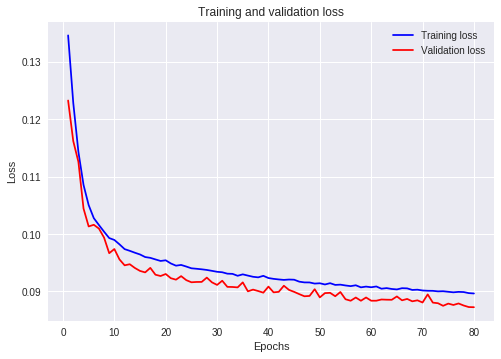

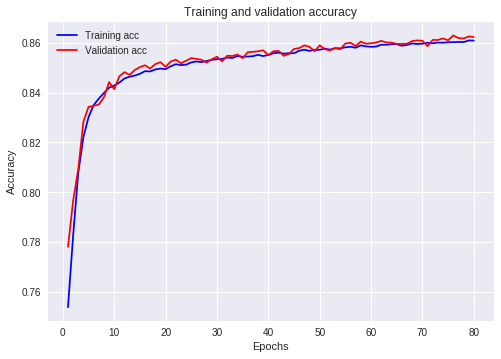

In [7]:
num_epoche = 80
conv = 16
conv_kernel=7
drop = 0
activation = 'tanh'
poolSize = 5
batchSize=32
validationSplit=0.1
adam = Adam(lr=1e-1)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
rmsprop = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
optimizer = 'adam'

input_layer = layers.Input(shape=(max_num_amino,len(dataindex)), name='input')

net = layers.Conv1D(conv,conv_kernel, padding='same')(input_layer)

net = layers.Activation(activation)(net)

#net = layers.MaxPooling1D(pool_size=poolSize,strides=1,padding='same')(net)

net = layers.Dropout(drop)(net)

net = layers.Conv1D(conv*2, conv_kernel, padding='same')(net)

net = layers.Activation(activation)(net)

net = layers.MaxPooling1D(pool_size=poolSize,strides=1,padding='same')(net)

net = layers.Dropout(drop)(net)

net = layers.Conv1D(conv*3, conv_kernel, padding='same')(net)

net = layers.Activation(activation)(net)

net = layers.MaxPooling1D(pool_size=poolSize,strides=1,padding='same')(net)

net = layers.Dropout(drop)(net)

net = layers.Dense(32)(net)
net = layers.Activation(activation)(net)
net = layers.Dropout(drop)(net)

output_layer = layers.Dense(2, activation=stable_softmax, name='output')(net) 

model = Model(inputs=input_layer, outputs=output_layer)


model.compile(optimizer=optimizer,#rmsprop,adam,SGD,adamax
              #loss='categorical_crossentropy',
              loss=proteinCategoricalCrossentropy,
              metrics=[weighted_accuracy])

model.summary()
model_summary= (str(model.to_json()))
# Fit the model

time_start = time.time()

history = model.fit(traindata,trainlabel,epochs=num_epoche,verbose=1,batch_size=batchSize,#validation_split=validationSplit)
                    callbacks=[ProteinCallback((testdata,testlabel))],
                    validation_data=(valdata,vallabel))
time_execution = time.time() - time_start
print("Fit time: ",time_execution)

test_score= model.evaluate(testdata, testlabel)
print("Loss ",test_score[0])
print("Accuracy ",test_score[1])

k=randint(0, 3000)
testd=traindata[k:(k+700),:,:]
testl=trainlabel[k:(k+700),:,:]
print('Random test set: from ',k,' to ',k+700)
test_score= model.evaluate(testd, testl)
print("Loss ",test_score[0])
print("Accuracy ",test_score[1])

loss = [x  for x in history.history['loss']]
val_loss = [x for x in history.history['val_loss'] ]

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

acc_values =[x for x in history.history['weighted_accuracy']]
val_acc_values = [x for x in history.history['val_weighted_accuracy']]

plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



In [0]:
#GRID SEARCH
#TEST DROP + TEST ACTIVATION + TEST CONV FILTERS + TEST CONV SIZE

import keras

def create_model(traindata,trainlabel,valdata,vallabel,opt,batch,nep,conv_filters,conv_size,activation,do_pooling,poolSize,drop,cb_list):

  input_layer = layers.Input(shape=(max_num_amino,len(dataindex)), name='input')

  net = layers.Conv1D(conv_filters,conv_size, padding='same')(input_layer)

  net = layers.Activation(activation)(net)

  #net = layers.MaxPooling1D(pool_size=poolSize,strides=1,padding='same')(net)

  net = layers.Dropout(drop)(net)

  net = layers.Conv1D(conv_filters, conv_size, padding='same')(net)

  net = layers.Activation(activation)(net)

  if do_pooling:
    net = layers.MaxPooling1D(pool_size=poolSize,strides=1,padding='same')(net)

  net = layers.Dropout(drop)(net)

  net = layers.Conv1D(conv_filters, conv_size, padding='same')(net)

  net = layers.Activation(activation)(net)

  if do_pooling:
    net = layers.MaxPooling1D(pool_size=poolSize,strides=1,padding='same')(net)

  net = layers.Dropout(drop)(net)

  net = layers.Dense(conv)(net)
  net = layers.Activation(activation)(net)
  net = layers.Dropout(drop)(net)

  output_layer = layers.Dense(2, activation="softmax", name='output')(net) 

  model = Model(inputs=input_layer, outputs=output_layer)
  
  model.compile(optimizer=opt,
                loss=proteinCategoricalCrossentropy,
                metrics=[weighted_accuracy])
  history = model.fit(traindata,trainlabel,epochs=nep,verbose=2,callbacks=cb_list,batch_size=batch,validation_data=(valdata,vallabel))
  return model,history

adam = Adam(lr=0.001)

ep = 120
optimizers = [adam]
batch_sizes = [32]
pool_sizes = [2]
conv_units = [32]#[16,32,64,128]
conv_kernel_size = [7]#[2,5,7]
drops = [0]#,0.1,0.25,0.5]
activations =  [ 'tanh','relu','sigmoid'] #TODO fare drop. 0.25 + sigmoid
do_pool = [True]#TODO rifare senza pooling
histories = []
test_scores = []

time_start_tests = time.time()

with open("grid_search_"+ep+"eps.txt", "w") as txt:
  txt.write("")
k=0
tot = len(optimizers)*len(conv_units)*len(conv_kernel_size)*len(pool_sizes)*len(drops)*len(activations)

for optimizer in optimizers:
  for act in activations:
    for pool in pool_sizes:
      for do_p in do_pool:
        for batch in batch_sizes:
          for conv in conv_units:
            for conv_kernel in conv_kernel_size:
              for drop in drops:
                k=k+1
                if k<1:#test già fatti
                  break
                print("Test ",k," su ",tot," Epochs ",ep," - Optimizer ",optimizer," - BatchSize",batch," - Activation ",act," - conv size ",conv,
                      " - conv kernel ",conv_kernel," - do pool ",do_p," - pool size ",pool," - drop size",drop)

                time_start = time.time()

                callbacks_list = []

                m,h=create_model(traindata,trainlabel,valdata,vallabel,optimizer,batch,ep,conv_kernel,conv,act,do_p,pool,drop,callbacks_list)

                histories.append(h)

                time_execution = time.time() - time_start

                model_summary= (str(m.to_json()))

                test_score= m.evaluate(testdata, testlabel,verbose=0)
                test_scores.append(test_score)
                print("TEST: Loss ",test_score[0]," - Accuracy ",test_score[1],' in sec. ',time_execution)

                with open("grid_search_"+ep+"eps.txt", "a") as txt:
                  txt.write("Test %s su %s, activation: %s, conv_filters: %s, conv_kernel_size: %s, do_pooling:%s, pool_size: %s, drop: %s, time:%s --- ACC: %s | LOSS: %s\n"% (k,tot,act,conv,conv_kernel,do_p,pool,drop,time_execution,test_score[1],test_score[0]))
                  txt.write("Losses: [")
                  for x in h.history['loss']:
                    txt.write(" %s ," % (x))
                  txt.write("]\n")
                  txt.write("Val losses: [")
                  for x in h.history['val_loss']:
                    txt.write(" %s ," % (x))
                  txt.write("]\n")
                  txt.write("Acc: [")
                  for x in h.history['weighted_accuracy']:
                    txt.write(" %s ," % (x))
                  txt.write("]\n")
                  txt.write("Val acc: [")
                  for x in h.history['val_weighted_accuracy']:
                    txt.write(" %s ," % (x))
                  txt.write("]\n")

print('-----Total execution: ',time.time() - time_start_tests)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'grid_search_'+ep+'eps.txt'})
uploaded.SetContentFile('grid_search_'+ep+'eps.txt')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))










In [43]:
!ls
from google.colab import files
files.download('grid_search_120eps.txt')

cullpdb+profile_6133_filtered.npy.gz  grid_search_120eps.txt
datalab				      model_250epoche_cnn.h5


#  Convolution + Bidirectional LSTM


In [0]:
#CONVOLUTION + LSTM
#Note: make it run only if you have 6 hours to lose :-)

time_start_tests = time.time()

input_layer = layers.Input(shape=(max_num_amino,30), name='input')

cnn1 = layers.Conv1D(16,3, padding='same')(input_layer)
cnn2 = layers.Conv1D(16,5, padding='same')(input_layer)
cnn3 = layers.Conv1D(16,7, padding='same')(input_layer)
max_p1 = layers.MaxPool1D(5,strides=1,padding='same')(cnn1)
max_p2 = layers.MaxPool1D(5,strides=1,padding='same')(cnn2)
max_p3 = layers.MaxPool1D(5,strides=1,padding='same')(cnn3)

mergeCNN = layers.Concatenate(axis=-1)([max_p1,max_p2,max_p3])

dense1 = layers.Dense(64, activation="relu")(mergeCNN)

#drop1 = layers.Dropout(0.5)(dense1)

bidi = layers.Bidirectional(layers.LSTM(400,kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),
                bias_initializer='zeros', return_sequences=True), input_shape=(max_num_amino, 30))(dense1)
dense2 = layers.Dense(64, activation="relu")(bidi)

drop2 = layers.Dropout(0.5)(dense2)

dense3 = layers.Dense(32, activation="relu")(drop2)

output_layer = layers.Dense(2, activation="softmax")(dense3)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=optimizers.RMSPROP(lr=10, rho=0.95),#'adam',
              loss='categorical_crossentropy',
              metrics=[weighted_accuracy])
model.summary()

history_lstm_120ep = model.fit(traindata,trainlabel,epochs=120,batch_size=128,callbacks=[ProteinCallback((testdata,testlabel))],
          validation_data=(valdata,vallabel))

print('-----Total execution: ',time.time() - time_start_tests)

test_score= model.evaluate(testdata, testlabel)
print("Loss ",test_score[0])
print("Accuracy ",test_score[1])

loss = history_lstm_120ep.history['loss']
val_loss = history_lstm_120ep.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

acc_values =history_lstm_120ep.history['weighted_accuracy']
val_acc_values = history_lstm_120ep.history['val_weighted_accuracy']

plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_30epoche_lstm_v3.h5")

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'model_30epoche_lstm_v3.h5'})
uploaded.SetContentFile('model_30epoche_lstm_v3.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

np.save('history_30epoche_lstm_v3.npy',np.array(history_lstm_120ep))

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'history_30epoche_lstm_v3.npy'})
uploaded.SetContentFile('history_30epoche_lstm_v3.npy')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))